# PART 2: ANALYZING AND VISUALIZING DATA

In this notebook, I'll be using the 3 dataframes created previously to analyze 311 complaints in NYC in 2017. I'll explore the following:

1. Number of 10 most common complaint types per borough
2. Number of 10 most common complaint types per zip code (only the 10 most populous)
3. Complaint index for each borough (adjusted for population)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [2]:
# Load DataFrames from Part 1
nyc2_df = pd.read_pickle('nyc2_df.pkl')
census_df = pd.read_pickle('census_df.pkl')
zips_df = pd.read_pickle('zips_df.pkl')

In [3]:
# Create list of 10 most common complaint types
complaints = nyc2_df['complaint_type'].value_counts().head(10).keys().tolist()
complaints

['NOISE - RESIDENTIAL',
 'HEAT/HOT WATER',
 'ILLEGAL PARKING',
 'BLOCKED DRIVEWAY',
 'STREET CONDITION',
 'STREET LIGHT CONDITION',
 'UNSANITARY CONDITION',
 'NOISE - STREET/SIDEWALK',
 'WATER SYSTEM',
 'NOISE']

In [4]:
# plot1_dict = {COMPLAINT1: [BOROUGH1_AMT, BOROUGH2_AMT, ...], COMPLAINT2: [...]}
plot1_dict = {}

# Get list of boroughs in alphabetical order from NYC zip code dataframe
boroughs = sorted(list(zips_df['borough'].unique()))

for complaint in complaints:
    perBorough = []
    for borough in boroughs:
        perBorough.append(len(nyc2_df[(nyc2_df['complaint_type'] == complaint) \
                                      & (nyc2_df['borough'] == borough)]))
    plot1_dict[complaint] = perBorough

In [5]:
pd.DataFrame.from_dict(plot1_dict, orient='index', columns=boroughs)

,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
NOISE - RESIDENTIAL,57687,67663,51055,46415,7037
HEAT/HOT WATER,68718,66984,46529,29217,2073
ILLEGAL PARKING,16136,55469,19735,46134,8060
BLOCKED DRIVEWAY,24592,49387,3431,54370,3794
STREET CONDITION,11761,25432,14840,30633,10591
STREET LIGHT CONDITION,18410,22458,11077,24258,6666
UNSANITARY CONDITION,24561,26659,14635,11474,1953
NOISE - STREET/SIDEWALK,14028,21317,29157,7532,867
WATER SYSTEM,10221,19809,10930,18792,5348
NOISE,3134,15421,29002,10685,1926


Sanity check: The total amount of complaints across all boroughs should be no more
than the total amount for the whole database since several records are missing
borough/zip code data.

In [6]:
for complaint in complaints:
    print(complaint)
    print(len(nyc2_df[(nyc2_df['complaint_type'] == complaint)]), '>=', 
          sum(plot1_dict[complaint]))

NOISE - RESIDENTIAL
230152 >= 229857
HEAT/HOT WATER
213521 >= 213521
ILLEGAL PARKING
146122 >= 145534
BLOCKED DRIVEWAY
136097 >= 135574
STREET CONDITION
93265 >= 93257
STREET LIGHT CONDITION
84195 >= 82869
UNSANITARY CONDITION
79282 >= 79282
NOISE - STREET/SIDEWALK
73085 >= 72901
WATER SYSTEM
65100 >= 65100
NOISE
60171 >= 60168


<IPython.core.display.Javascript object>


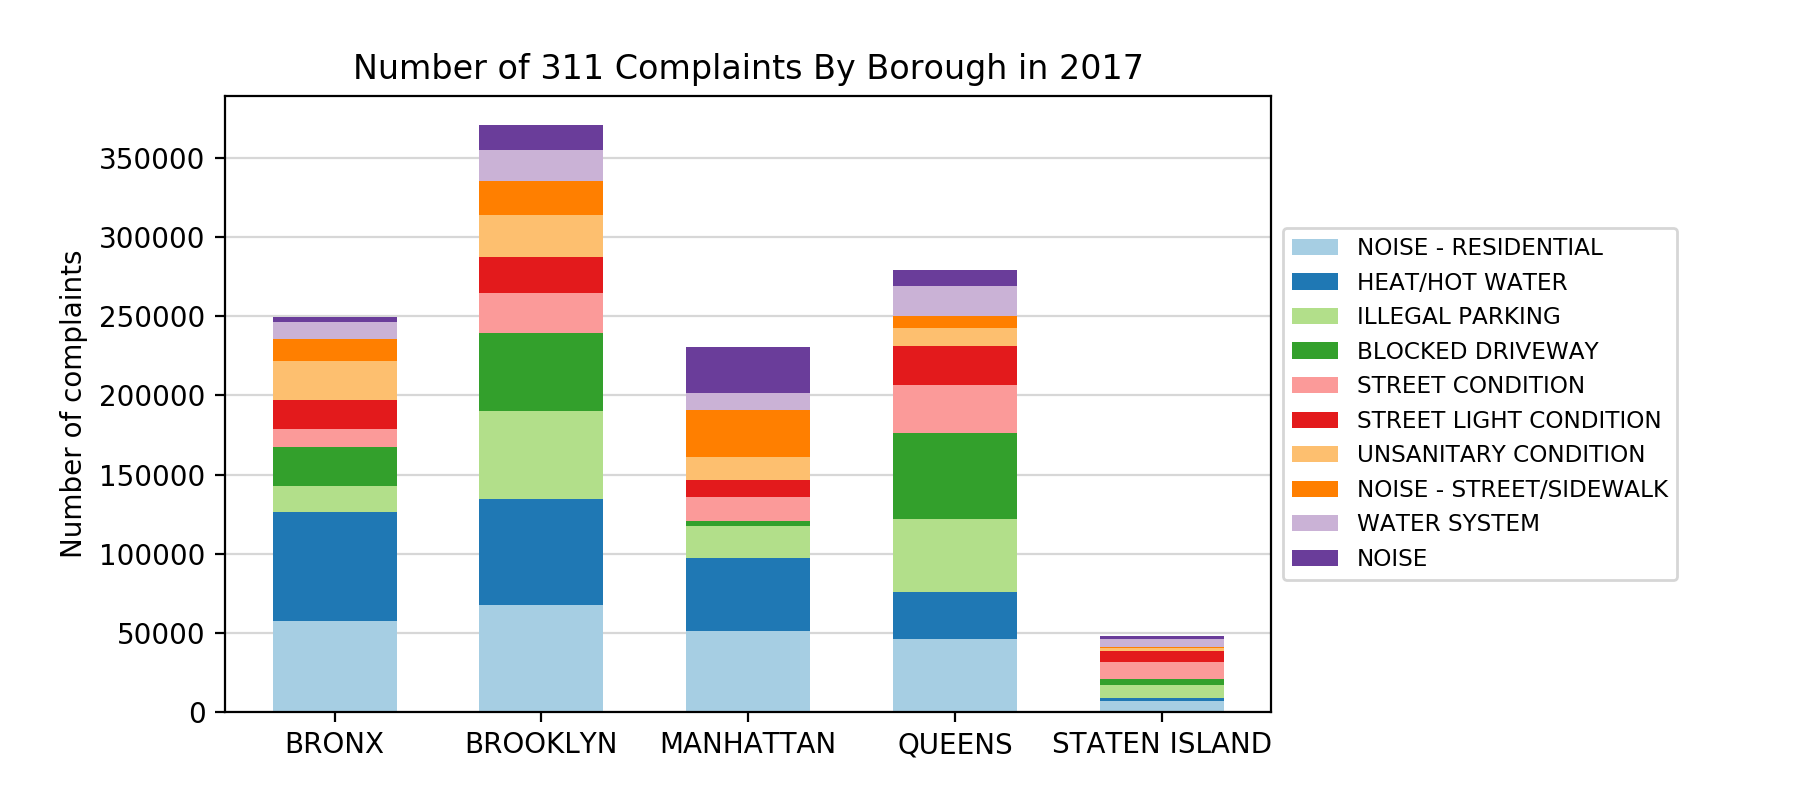

In [8]:
cmap = plt.get_cmap("Paired")
plt.rc('axes', axisbelow=True)

def stackedPlot(p_dict, areas, ax, width):
    ind = np.arange(len(areas)) 
    p = []
    p.append(ax.bar(ind, p_dict[complaints[0]], 
                     color=cmap(0), width=width))
    bottoms = [0]*len(areas)
    for idx in range(1, len(complaints)):
        bottoms = [sum(x) for x in \
                   zip(bottoms, p_dict[complaints[idx-1]])]
        p.append(ax.bar(ind, p_dict[complaints[idx]],
                         color=cmap(idx), width=width, bottom=bottoms))
    plt.ylabel('Number of complaints')
    plt.xticks(ind, areas)
    plt.grid(axis='y', alpha=0.5)
    
    
width = 0.6
plt.figure(figsize=(9, 4))
ax = plt.subplot(111)

# Call Function
stackedPlot(plot1_dict, boroughs, ax, width)

plt.ylabel('Number of complaints')
plt.title('Number of 311 Complaints By Borough in 2017')

plt.legend(complaints, loc='center left', bbox_to_anchor=(1, 0.5),
           fontsize='small')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

plt.show()

In [9]:
def areaPlots(p_dict, areas, z, ax, width):
    ind = np.arange(len(complaints))
    p = []

    for idx in range(len(complaints)):
        p.append(ax.bar(ind[idx], p_dict[complaints[idx]][z], 
                        color=cmap(idx), width=width))

    plt.ylabel('Number of complaints')
    plt.title(areas[z])
    plt.xticks([],[])
    plt.minorticks_on()
    plt.grid(axis='y', which='major', alpha=0.5)
    plt.grid(axis='y', which='minor', alpha=0.2)

<IPython.core.display.Javascript object>


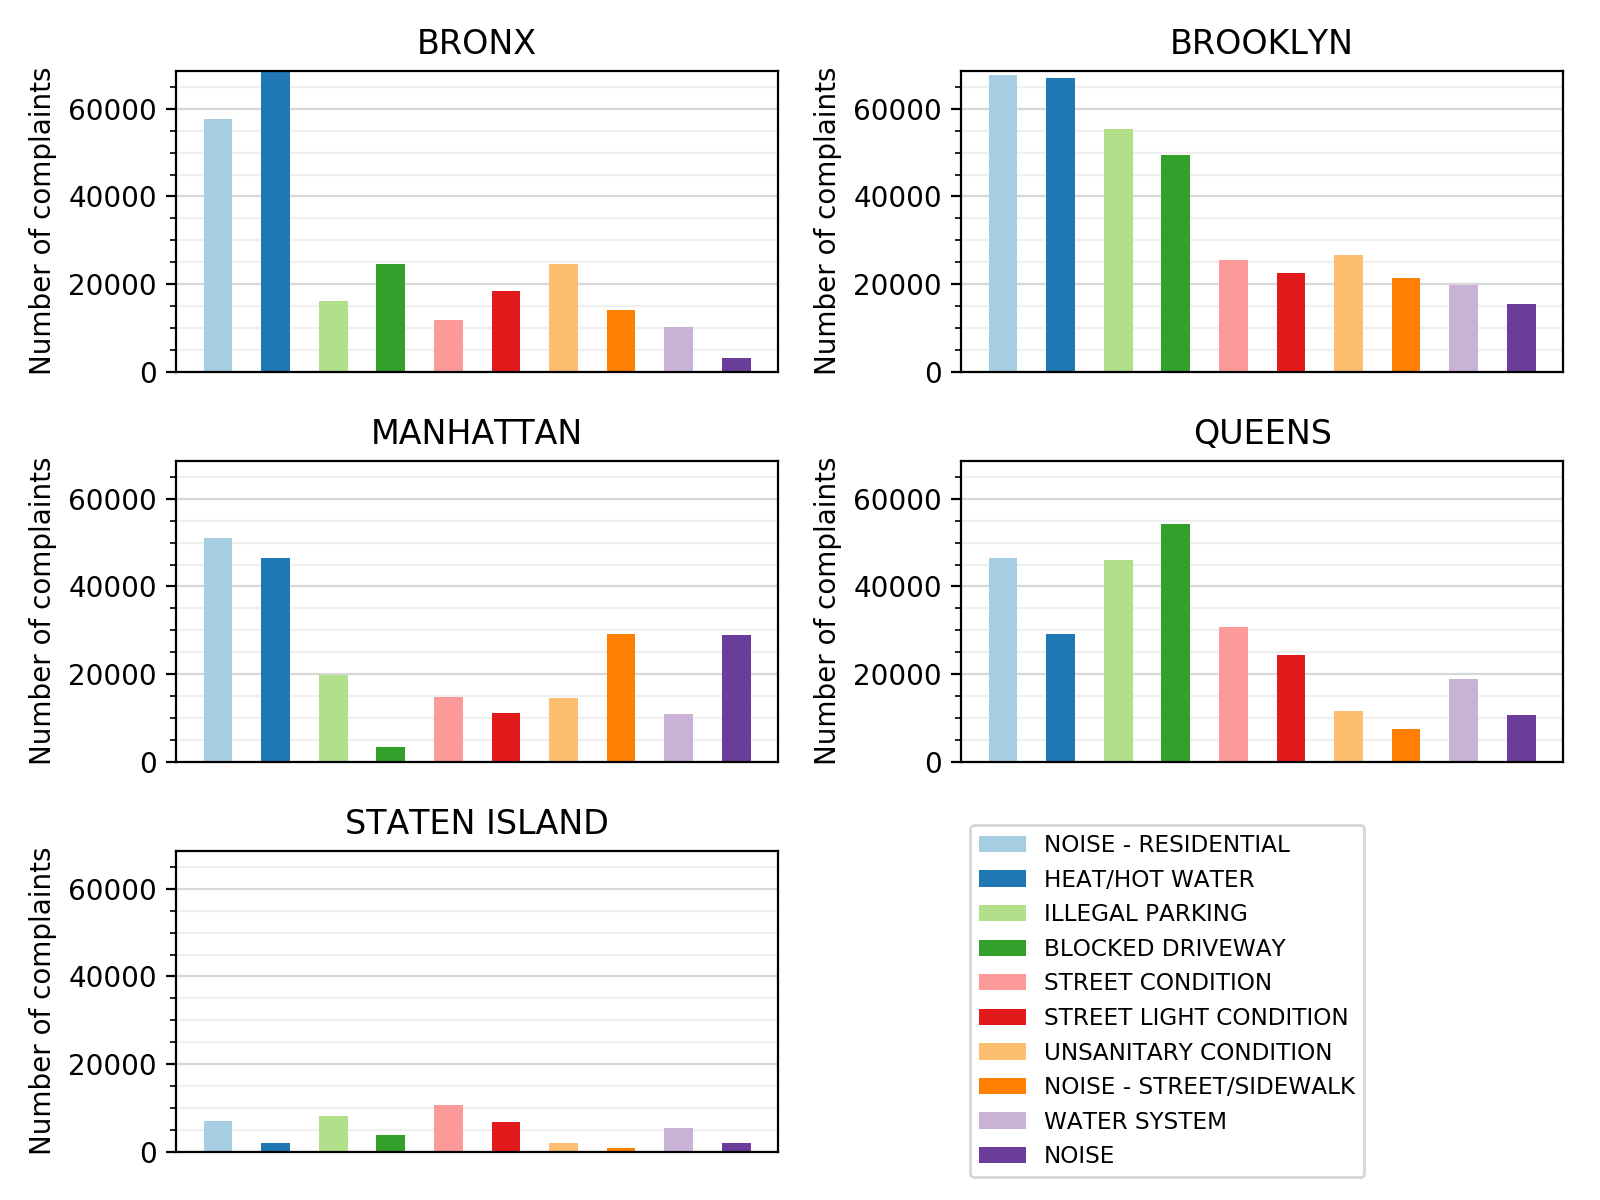

In [10]:
width = 0.5     

plt.figure(figsize=(8, 6))
for idx in range(len(boroughs)):
    ax = plt.subplot(321+idx)
    areaPlots(plot1_dict, boroughs, idx, ax, width)
    ax.set_ylim([0, max([max(v) for v in plot1_dict.values()])])

plt.tight_layout()
plt.legend(complaints, loc='center left', bbox_to_anchor=(1.3, 0.5),
           fontsize = 'small')


plt.show()

In [11]:
# Find the most populous zip codes
# Get list of zip codes from NYC zip code dataframe
zip_codes = list(zips_df['zip_code'].unique())
len(zip_codes)

240

In [12]:
# Find a match, if one exists, in the 2010 Census dataframe for each
# NYC zip code. If found, store the zip code and population as a tuple
# in new borough dictionary. e.g. 'MANHATTAN':[('10001', 21102), ...]

borough_dict = {b:[] for b in boroughs}
notInCensus = 0

for zc in zip_codes:
    p_df = census_df[census_df['Zip Code ZCTA'] == zc]
    if len(p_df) == 1:
        bkey = zips_df[zips_df['zip_code'] == zc].iloc[0]['borough']
        borough_dict[bkey].append((zc, p_df.iloc[0]['2010 Census Population']))
    elif len(p_df) == 0:
        #print(zc, len(p_df))
        notInCensus += 1
    else:
        print('Duplicate?', zc)
        
print('{} out of {} NYC zip codes did not have a matching record in the 2010 Census database.'
      .format(notInCensus, len(zip_codes)))

35 out of 240 NYC zip codes did not have a matching record in the 2010 Census database.


In [13]:
# Convoluted way to flatten dictionary lists of tuples into one list
biggest_zc = [bpair for blist in list(borough_dict.values()) for bpair in blist]
biggest_zc.sort(key=lambda x: x[1], reverse=True)
biggest_zc = [z[0] for z in biggest_zc[:10]]

In [14]:
# plot2_dict = {COMPLAINT1: [ZIP1_AMT, ZIP2_AMT, ...], COMPLAINT2: [...]}
plot2_dict = {}

for complaint in complaints:
    perZipCode = []
    for bzc in biggest_zc:
        perZipCode.append(len(nyc2_df[(nyc2_df['complaint_type'] == complaint) \
                                      & (nyc2_df['incident_zip'] == bzc)]))
    plot2_dict[complaint] = perZipCode

In [15]:
pd.DataFrame.from_dict(plot2_dict, orient='index', columns=biggest_zc)

,11368,11226,11373,11220,11385,10467,10025,11208,11236,11207
NOISE - RESIDENTIAL,2460,4854,1842,1522,2609,5807,2085,2795,1929,3061
HEAT/HOT WATER,1620,7569,3408,1634,1526,6041,2397,2052,1145,2461
ILLEGAL PARKING,1251,1076,1277,2013,4135,986,736,2150,1431,1500
BLOCKED DRIVEWAY,4384,2203,2635,1558,3042,2068,125,2756,3041,2062
STREET CONDITION,561,491,691,690,1232,612,628,816,1021,1142
STREET LIGHT CONDITION,444,202,362,610,791,407,21,566,180,932
UNSANITARY CONDITION,639,3155,756,719,647,2192,714,1341,562,1621
NOISE - STREET/SIDEWALK,684,1831,304,498,607,713,1224,825,201,558
WATER SYSTEM,617,406,372,674,1240,560,481,710,623,757
NOISE,158,440,270,442,507,285,1398,188,108,199


<IPython.core.display.Javascript object>


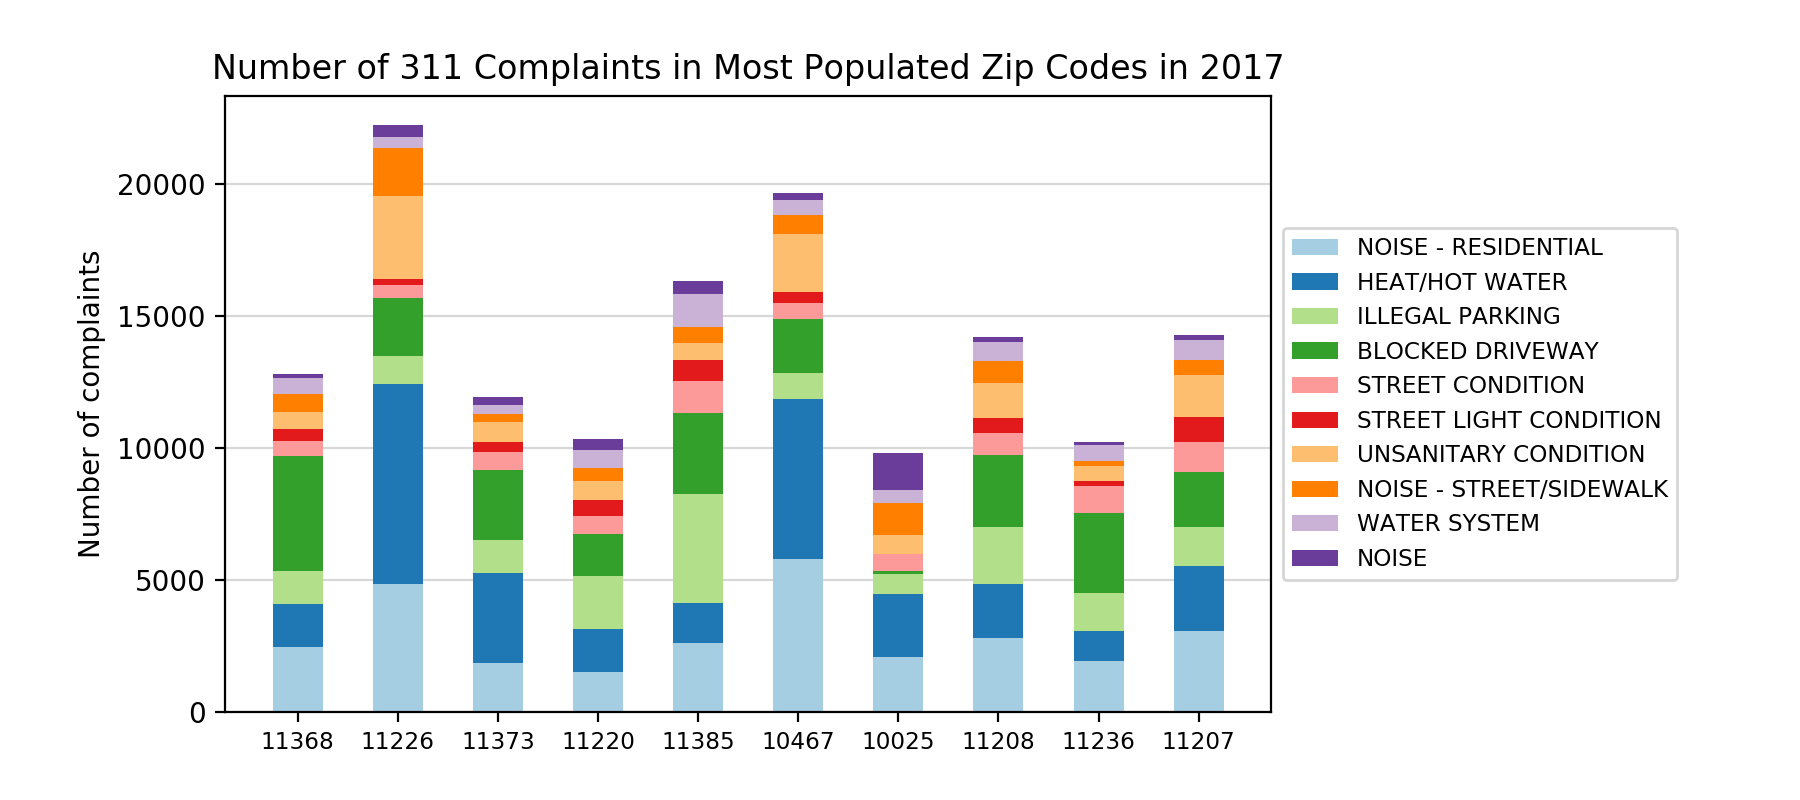

In [17]:
width = 0.5 
plt.figure(figsize=(9, 4))
ax = plt.subplot(111)

# Call function
stackedPlot(plot2_dict, biggest_zc, ax, width)

ax.set_xticklabels(biggest_zc, fontsize='small')

plt.title('Number of 311 Complaints in Most Populated Zip Codes in 2017')

plt.legend(complaints, loc='center left', bbox_to_anchor=(1, 0.5),
           fontsize='small')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

plt.show()

<IPython.core.display.Javascript object>


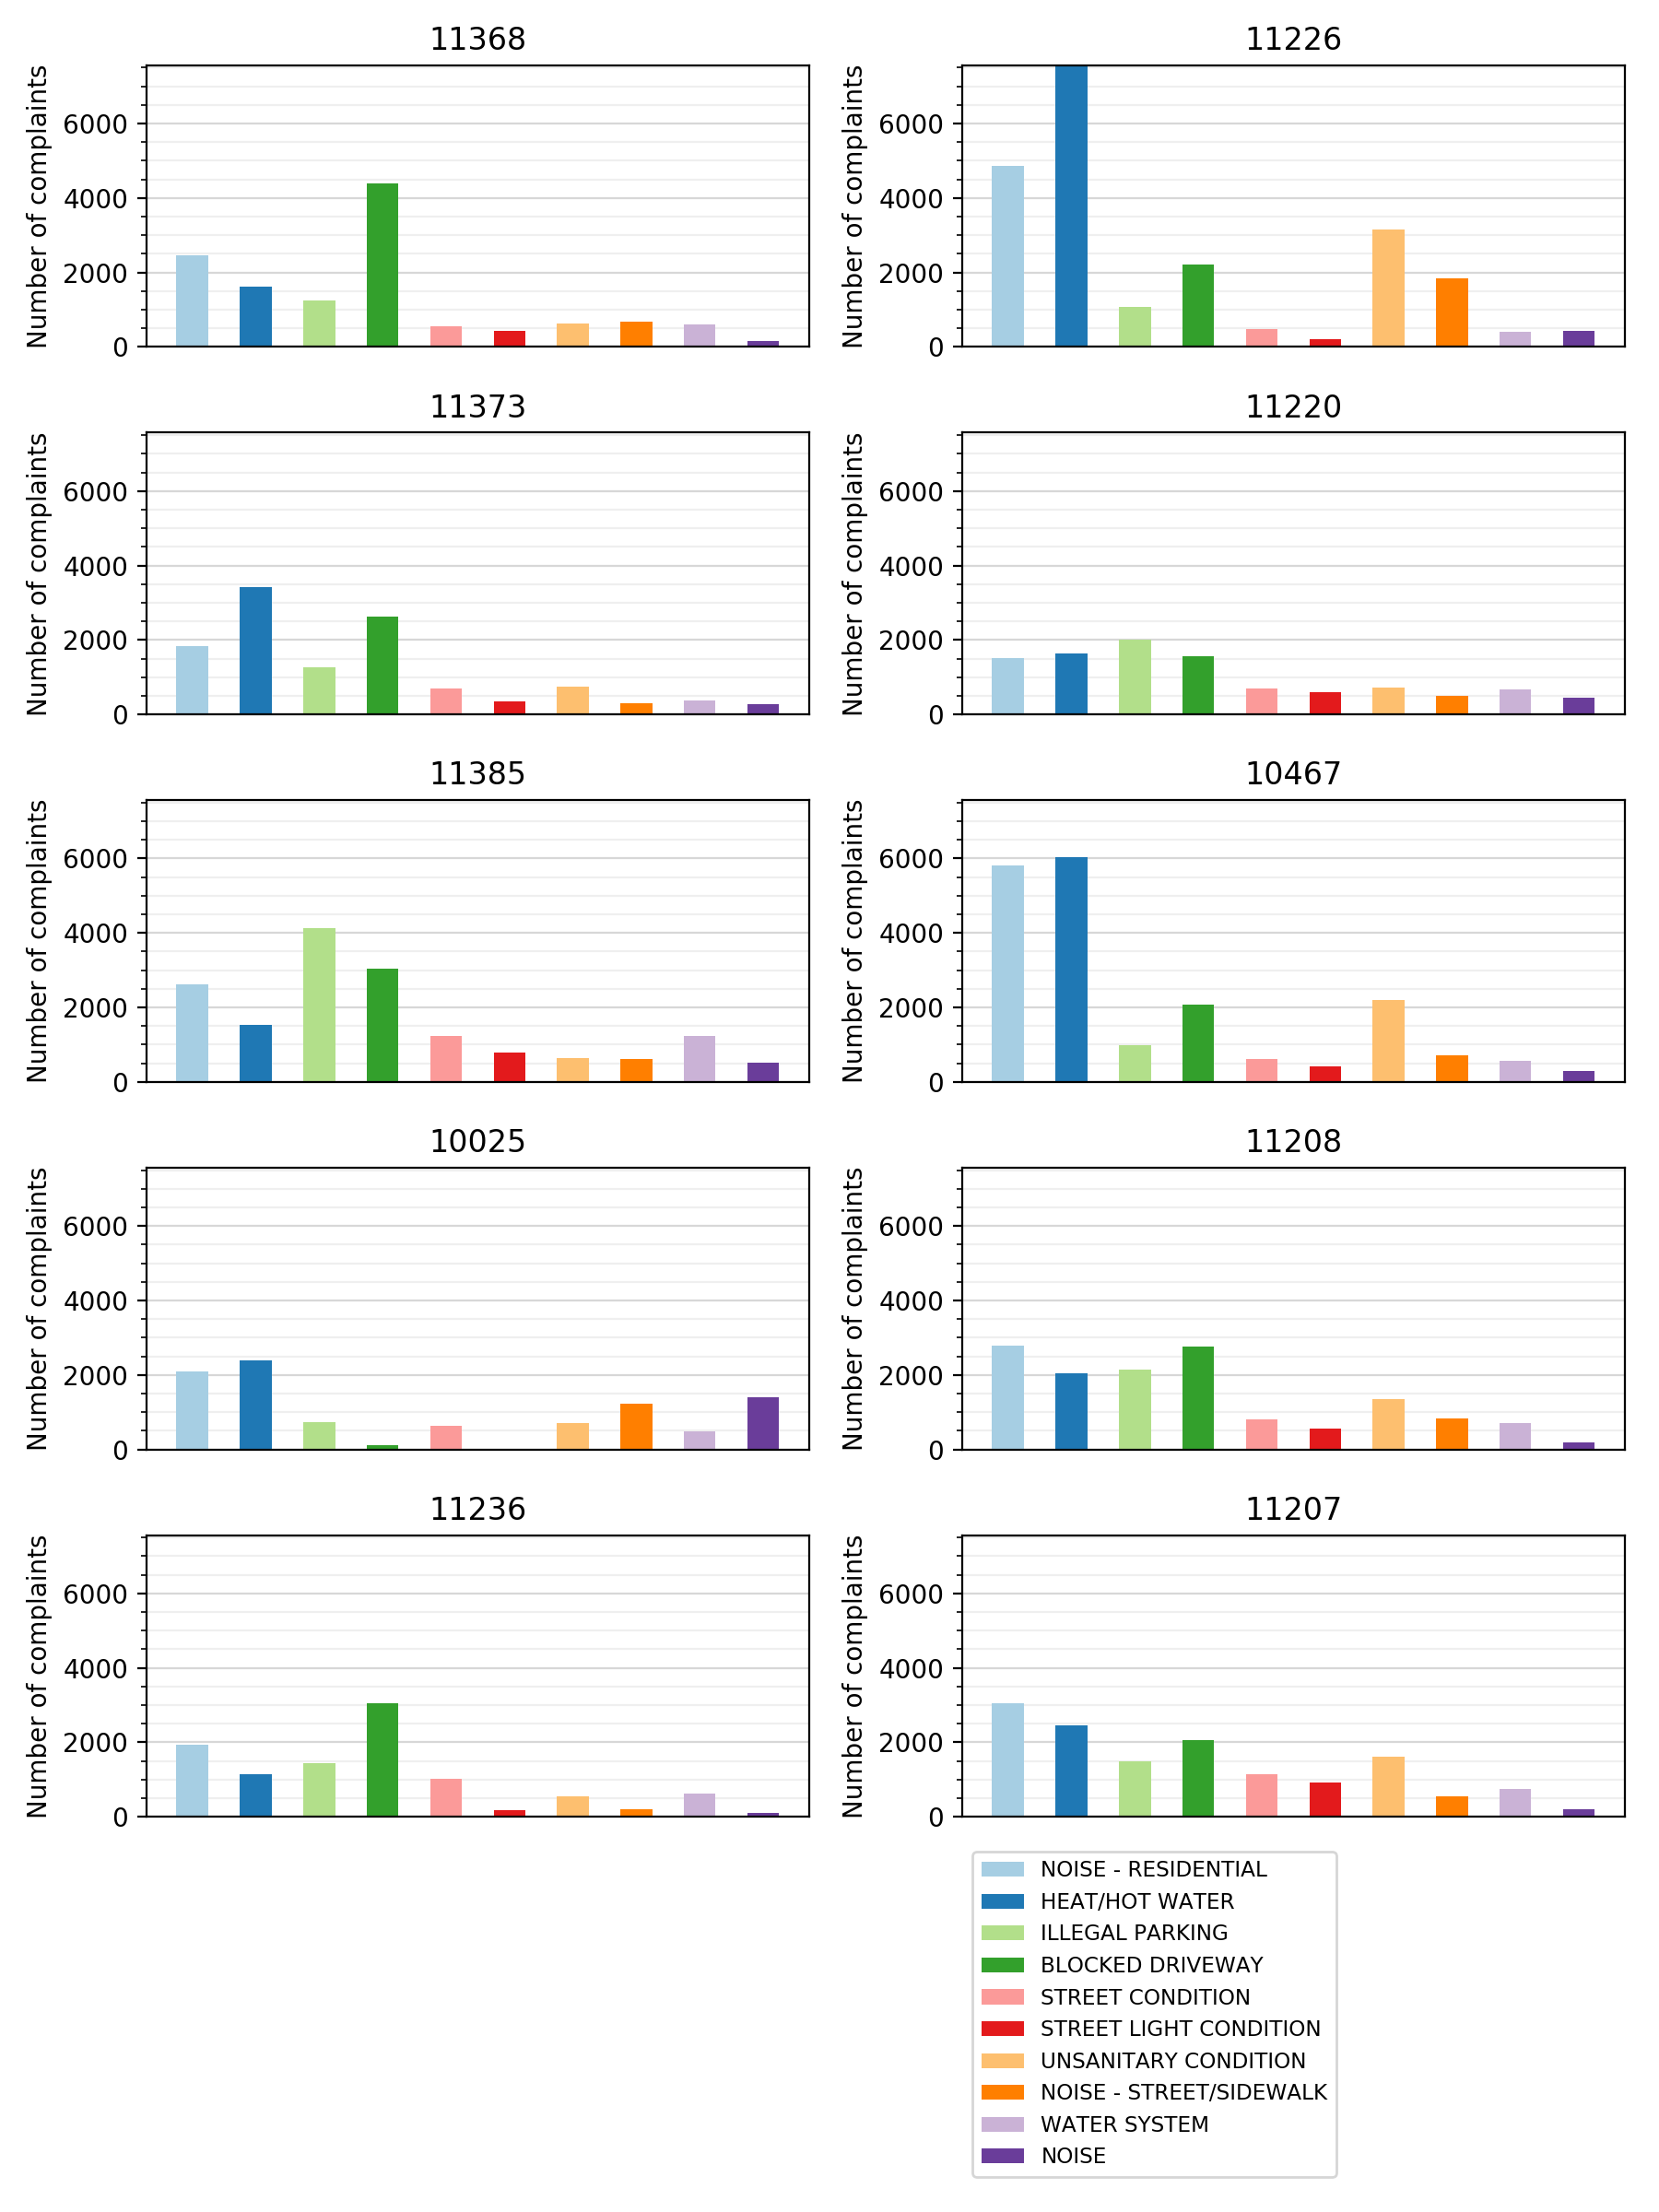

In [18]:
width = 0.5     

plt.figure(figsize=(9, 12))
for idx in range(len(biggest_zc)):
    ax = plt.subplot(6,2,1+idx)
    areaPlots(plot2_dict, biggest_zc, idx, ax, width)
    ax.set_ylim([0, max([max(v) for v in plot2_dict.values()])])

plt.tight_layout()
plt.legend(complaints, loc='center left', bbox_to_anchor=(0,-0.7),
           fontsize = 'small')


plt.show()

In [19]:
# Plot 3
# plot3_dict = {BOROUGH: [NUM_COMPLAINTS, POPULATION], ...}

plot3_dict = {}

for b in boroughs:
    # Get total number of complaints
    numComplaints = len(nyc2_df[nyc2_df['borough'] == b])
    borPop = sum([bd[1] for bd in borough_dict[b]])
    plot3_dict[b] = [numComplaints, borPop]
    
plot3_dict

{'BRONX': [451039, 1382480],
 'BROOKLYN': [771659, 2504700],
 'MANHATTAN': [480606, 1518994],
 'QUEENS': [590318, 2233454],
 'STATEN ISLAND': [129485, 468730]}

In [20]:
totalComplaints = len(nyc2_df)
totalPopulation = sum([p[1] for p in plot3_dict.values()])

plot3_dict['NYC TOTAL'] = [totalComplaints, totalPopulation]

# Calculate index by dividing complaints by population (i.e. complaints per person)
for region in plot3_dict.keys():
    plot3_dict[region].append(plot3_dict[region][0]/float(plot3_dict[region][1]))
    
# Normalize index by dividing by NYC TOTAL average index
for region in plot3_dict.keys():
    plot3_dict[region].append(plot3_dict[region][2]/float(plot3_dict['NYC TOTAL'][2]))

In [21]:
pd.DataFrame.from_dict(plot3_dict, orient='index', 
                       columns=['Complaints', 'Population', 'Complaint Index', 'Normalized'])

,Complaints,Population,Complaint Index,Normalized
BRONX,451039,1382480,0.326254,1.074830
BROOKLYN,771659,2504700,0.308084,1.014973
MANHATTAN,480606,1518994,0.316398,1.042360
QUEENS,590318,2233454,0.264307,0.870750
STATEN ISLAND,129485,468730,0.276246,0.910084
NYC TOTAL,2461208,8108358,0.303540,1.000000


# Complaint Index

In the table above, the number of complaints for each borough is divided by its population. This yields a complaint-per-person value, which we'll informally call a "complaint index".

Further, these complaint index values are normalized by dividing by the complaint-per-person value for all of NYC. Dividing each borough average by the overall average sets any mean value to 1.0. More complaints are higher, and fewer complaints are lower, naturally.